In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))
sys.path.append(str(Path.cwd().parent / 'label_anything' / 'data'))
from label_anything.data.transforms import PromptsProcessor
import os
import numpy as np
import cv2
from shapely.geometry import Polygon
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools import mask as mask_utils

2913
(500, 281) (500, 281)


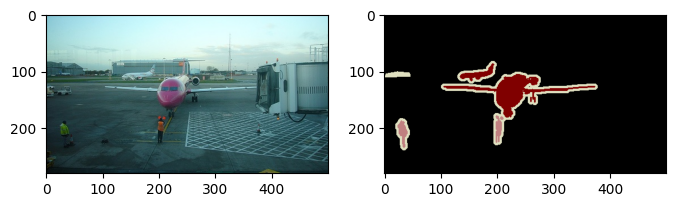

In [19]:
def _read_image_ids(image_sets_file):
    ids = []
    with open(image_sets_file) as f:
        for line in f:
            ids.append(line.rstrip())
    return ids

root = pathlib.Path("/home/emanuele/Dottorato/dataset-vari/VOC2012")
images_file = os.path.join(root, "ImageSets", "Segmentation", "dataset.txt")
ids = _read_image_ids(images_file)
print(len(ids))
image_id = "2007_000032"
img_file = os.path.join(root, "JPEGImages", image_id + ".jpg")
mask_file = os.path.join(root, "SegmentationClass", image_id + ".png")
img = Image.open(img_file).convert("RGB")
mask = Image.open(mask_file)
mask_array = np.array(mask)
print(img.size, mask.size)
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [9]:
mask_file = os.path.join(root, "SegmentationClass", image_id + ".png")
mask_array = np.array(Image.open(mask_file))
unique_values = np.unique(mask_array)
unique_values

array([ 12, 255], dtype=uint8)

In [16]:
def get_masks(root, image_id):
    mask_file = os.path.join(root, "SegmentationClass", image_id + ".png")
    mask_array = np.array(Image.open(mask_file))
    unique_values = np.unique(mask_array)
    print(unique_values)
    masks = {}

    for value in unique_values:
        masks[value] = np.where(mask_array == value, 1, 0)

    l_mask = None
    if 0 in masks and 255 in masks:
        l_mask = masks.get(0) | masks.get(255)
        masks.pop(0)
        masks.pop(255)
    elif 0 in masks:
        l_mask = masks.get(0)
        masks.pop(0)
    elif 255 in masks:
        l_mask = masks.get(255)
        masks.pop(255)

    if l_mask is not None:
        masks[0] = l_mask

    rle_masks = {}
    for key, value in masks.items():
        rle_masks[key] = mask_utils.encode(np.asfortranarray(value.astype(np.uint8)))

    return rle_masks

In [17]:
rle_masks = get_masks(root, image_id)

[ 12 255]


In [18]:
rle_masks

{12: {'size': [375, 500],
  'counts': b'iUY14[;=I5L3M2N3N3L101O000VOnNoFR1n8QOQGP1m8ROSGo0YOROZ90]GV1b8kN^GU1`8nN^GS1a8nN_GS1_8nN`GS1^8oNbGQ1]8PObGQ1]8QOaGP1_8POaGP1^8TO^Gm0a8WOZGk0e8XOUGm0j8P1O1O1O1O2O1N1O2N2N2N2N2N2kGTM\\7d3O1O1O1O1O1N2N2N2O1O100O2O00000O1000000O100000000O1000000000000000000N2002OO01O00000000000000000000000000000O101O000000001O1O001O001O0dKoHR4]7N1O1O1O1O1O1O1O1O2N1O1O2N3M4L4L1O1O1N2O001O1]M`Gm1V9O101N1M3K5lNbFIm:H8E][k2'},
 0: {'size': [375, 500],
  'counts': b'0iUY14bUgN=I5L3M2N3N3L101O000VOnNoFR1n8QOQGP1m8ROSGo0YOROZ90]GV1b8kN^GU1`8nN^GS1a8nN_GS1_8nN`GS1^8oNbGQ1]8PObGQ1]8QOaGP1_8POaGP1^8TO^Gm0a8WOZGk0e8XOUGm0j8P1O1O1O1O2O1N1O2N2N2N2N2N2kGTM\\7d3O1O1O1O1O1N2N2N2O1O100O2O00000O1000000O100000000O1000000000000000000N2002OO01O00000000000000000000000000000O101O000000001O1O001O001O0dKoHR4]7N1O1O1O1O1O1O1O1O2N1O1O2N3M4L4L1O1O1N2O001O1]M`Gm1V9O101N1M3K5lNbFIm:H8E][k2'}}

In [21]:
def convert_mask(rle, h, w):
    """Convert annotation which can be polygons, uncompressed RLE, or RLE
    to binary mask.
    Args:
        mask: mask can be polygons, uncompressed RLE, or RLE
        h (int): image height
        w (int): image width

    Returns:
        binary mask (numpy 2D array)
    """
    matrix = mask_utils.decode(rle)
    # if matrix is made by all zeros
    if np.all(matrix == 0):
        if isinstance(mask, list):
            first_polygon = mask[0]
            fp_x, fp_y = int(first_polygon[0]), int(first_polygon[1])
            # check if fp_x and fp_y are within the image
            fp_x = min(fp_x, w - 1)
            fp_y = min(fp_y, h - 1)
            # check if fp_x and fp_y are negative
            fp_x = max(fp_x, 0)
            fp_y = max(fp_y, 0)
            matrix[fp_y, fp_x] = 1
        else:
            matrix[0, 0] = 1
    return matrix

In [25]:
allo = convert_mask(rle_masks[1], img.size[1], img.size[0])

[]

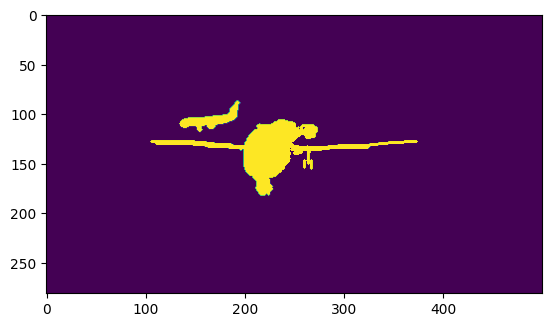

In [26]:
plt.imshow(allo)
plt.plot()

In [27]:
import logging
import cv2
from pycocotools import mask as cocomask
import copy

def rle_to_coco(annotation: dict) -> list[dict]:
    """Transform the rle coco annotation (a single one) into coco style.
    In this case, one mask can contain several polygons, later leading to several `Annotation` objects.
    In case of not having a valid polygon (the mask is a single pixel) it will be an empty list.
    Parameters
    ----------
    annotation : dict
        rle coco style annotation
    Returns
    -------
    list[dict]
        list of coco style annotations (in dict format)
    """

    annotation["segmentation"] = cocomask.frPyObjects(
        annotation["segmentation"],
        annotation["segmentation"]["size"][0],
        annotation["segmentation"]["size"][1],
    )

    maskedArr = cocomask.decode(annotation["segmentation"])
    contours, _ = cv2.findContours(maskedArr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []

    for contour in contours:
        if contour.size >= 6:
            segmentation.append(contour)

    if len(segmentation) == 0:
        logging.debug(
            f"Annotation with id {annotation['id']} is not valid, it has no segmentations."
        )
        annotations = []

    else:
        annotations = list()
        for i, seg in enumerate(segmentation):

            single_annotation = copy.deepcopy(annotation)
            single_annotation["segmentation_coords"] = (
                seg.astype(float).flatten().tolist()
            )
            single_annotation["bbox"] = list(cv2.boundingRect(seg))
            single_annotation["area"] = cv2.contourArea(seg)
            single_annotation["instance_id"] = annotation["id"]
            single_annotation["annotation_id"] = f"{annotation['id']}_{i}"

            annotations.append(single_annotation)

    return annotations


In [32]:
dio = (
    {
        "image_id": 1,
        "category_id": 1,
        "bbox": [
            485.0489501953125,
            660.6587524414062,
            13.161041259765625,
            10.61248779296875,
        ],
        "score": 0.8787025809288025,
        "segmentation": {
            "size": [960, 1280],
            "counts": "jXX>1mm03O1N10000000000001NY]mf0",
        },
        "id": 1,
        "iscrowd": 0,
        "attributes": {"occluded": False},
    },
)

rle_to_coco(dio)

TypeError: tuple indices must be integers or slices, not str